In [166]:
#loading libraries
import numpy as np
import scipy as sp
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import bokeh.plotting

# For interfacing with the file system
import glob
import subprocess
import os
import time

import importlib
import pipeline_dev
from pipeline_dev import bpy as bpy

# pipes bokeh output to the notebook
bokeh.io.output_notebook()
# enables some logging output
bpy.init_log(level='INFO')

Loading BokehJS ...

In [200]:
def compute_pw(df):
    # note that -D in config remove entries for diagonal alignments. You will need to add this back for similarity measures
    df_pw = bpy.run_minimap2(df, df, config='-k15 -w10 -p 0.9 -D --dual=no', cleanup=True)
    return bpy.get_best(df_pw,['query_id','database_id'],metric='AS', stat='idxmax')  # get the best alignment

# load data and concatenate dataframes
df_prf = pd.read_csv('pseudo_ref.csv.gz')
df_cl = pd.read_csv('pseudo_clst3.csv.gz')
df_ref = bpy.read_fasta('ref_db.fa')
df = pd.concat([df_prf, df_cl, df_ref])
df_pw = compute_pw(df[['id','sequence']])
df_pw.to_csv('pseudo_pw.csv.gz', index=False, compression='infer') # save the data

pid[1214279] 2020-05-06 22:07:44.788 INFO: Making directory ./minimap2/


In [201]:
def get_cluster(dist, metric='precomputed', alt=True, min_samples=None):
    # runs tsne on distance matrix
    tsne = bpy.run_TSNE(dist, metric=metric)
    # run hdbscan on tsne output
    hdb = bpy.cluster_HDBSCAN(tsne, metric='euclidean', min_samples=20, min_cluster_size=10)
    hdb = hdb.rename(columns={'cluster_id':'hdbscan_id','ordering':'hdbscan_order'})
    # merge the data
    optics = bpy.cluster_OPTICS(dist, metric='precomputed', alt_label=alt, min_samples=min_samples)
    optics = optics.rename(columns={'cluster_id':'optics_id','ordering':'optics_order'})
    tsne = tsne.merge(optics, on='id', how='left')
    return tsne.merge(hdb, on='id', how='left')

def get_dist_matrix(df):
    # extract the pairwise distance matrix and use match_score as the metric
    m = bpy.get_feature_vector(df[['query_id','database_id','match_score']], symmetric=True)
    # make this matrix symmetric
    m = bpy.get_symmetric_matrix(m, sym_larger=False)
    # invert similarity to distance
    for i in range(0,len(m)):
        m.iloc[:,i] = 1-m.iloc[:,i]
        m.iat[i,i] = 0 # set diagonal values to zero
    return m

# load pairwise data
df = pd.read_csv('pseudo_pw.csv.gz')
# get the distance matrix
m = get_dist_matrix(df)
# perform tsne, hdscan, and optics on the data
tsne = get_cluster(m, metric='precomputed', min_samples=20)
tsne.to_csv('pseudo_tsne.csv.gz', compression='infer', index=False)

pid[1214279] 2020-05-06 22:07:55.806 INFO: running sklearn tsne with n_comp = 2
pid[1214279] 2020-05-06 22:12:16.042 INFO: Running HDBSCAN
pid[1214279] 2020-05-06 22:12:16.367 INFO: getting and ordering the results
pid[1214279] 2020-05-06 22:12:16.399 INFO: number of clusters = 2
pid[1214279] 2020-05-06 22:12:16.401 INFO: unclustered = 9
pid[1214279] 2020-05-06 22:12:16.409 INFO: Running OPTICS
pid[1214279] 2020-05-06 22:12:16.565 INFO: max_eps = 0.5
pid[1214279] 2020-05-06 22:12:16.567 INFO: clust_OPTICS: iter=0 using min_samples=20
pid[1214279] 2020-05-06 22:12:21.653 INFO: clust_OPTICS: clusters=25 outliers=3461 delta=10.0
pid[1214279] 2020-05-06 22:12:21.654 INFO: using alt labeling
pid[1214279] 2020-05-06 22:12:23.046 INFO: n_clusters=25.0 n_unclustered=3490 N=5849


In [203]:
# load sequence data
prf = pd.read_csv('pseudo_ref.csv.gz')
prf['source'] = 'samples'
ref = bpy.read_fasta('ref_db.fa')
#ref = ref[[('HAP' in i) for i in ref['id']]]
ref['source'] = 'reference'
ref['ref_id'] = ref['id']
clst = pd.read_csv('pseudo_clst3.csv.gz')
clst['source'] = 'clst'
clst['clst_id'] = clst['id']
# align reference database to pseudo reference and pseudo reference clusters to pseudo reference
A = bpy.run_minimap2(prf, ref, config='-k8 -w1', cleanup=True).rename(columns={'query_id':'id'})
A = bpy.get_best(A,['id'],metric='match_score',stat='idxmax')
B = bpy.run_minimap2(prf, clst, config='-k8 -w1', cleanup=True).rename(columns={'query_id':'id'})
B = bpy.get_best(B,['id'],metric='match_score',stat='idxmax')
A = A.rename(columns={'database_id':'ref_id','match_score':'ref_match'})
B = B.rename(columns={'database_id':'clst_id','match_score':'clst_match'})
# merge alignment data
prf = prf.merge(A[['id','ref_id','ref_match']], on='id', how='left')
prf = prf.merge(B[['id','clst_id','clst_match']], on='id', how='left')
df = pd.concat([prf,ref,clst])
# merge into tsne
tsne = pd.read_csv('pseudo_tsne.csv.gz')
tsne = tsne.merge(df, on='id', how='left')
# add colors to ref_id
col = 'ref_id'
rid = np.unique(tsne[col].dropna())
cmap = bokeh.palettes.Category20b_20
colors = [cmap[i%len(cmap)] for i in range(0,len(rid))]
colors = pd.DataFrame(np.transpose([rid,colors]), columns=[col,'ref_id_color'])
tsne = tsne.merge(colors,on='ref_id',how='left')
# add colors to clst_id
col = 'clst_id'
rid = np.unique(tsne[col].dropna())
colors = [cmap[i%len(cmap)] for i in range(0,len(rid))]
colors = pd.DataFrame(np.transpose([rid,colors]), columns=[col,'clst_id_color'])
tsne = tsne.merge(colors,on='clst_id',how='left')

pid[1214279] 2020-05-06 22:12:44.135 INFO: Making directory ./minimap2/
pid[1214279] 2020-05-06 22:12:54.679 INFO: Making directory ./minimap2/


In [204]:
TOOLTIPS = [('id','@id'),
            ('ref_id', '@ref_id'),
            ('ref_match','@ref_match'),
            ('clst_id','@clst_id'),
            ('clst_match','@clst_match'),
            ('hdbscan_id','@hdbscan_id'),
            ('optics_id','@optics_id')]
p = bokeh.plotting.figure(plot_width=600, plot_height=500, tooltips=TOOLTIPS)

# plot samples colored by ref_match
d = tsne[tsne['source']=='samples']
mapper = bokeh.transform.linear_cmap(field_name='ref_match', palette=bokeh.palettes.Spectral11, low=0.8, high=1)
color_bar = bokeh.models.ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))
#p.circle('f_0', 'f_1', color=mapper, size=5, source=d)
p.circle('f_0', 'f_1', color='clst_id_color', size=5, source=d)

# plot cluster centers
d = tsne[tsne['source']=='clst']
p.square('f_0', 'f_1', line_color='black', fill_color='red', size=6, source=d)
d = tsne[tsne['source']=='reference']
p.diamond('f_0', 'f_1', line_color='black', fill_color='blue', size=10, source=d)

p.add_layout(color_bar, 'right')
bokeh.plotting.show(p)

In [ ]:
# Testing if split is a problem
cl = ['cluster11']
#cl = df_clst[df_clst['cluster_id']==2]['id']
print(cl)
rid = []
for i in cl:
    rid+= [r for r in tsne[tsne['clst_id']==i]['id']] 
    
df = pd.read_csv('pseudo_ref.csv.gz')
df = df[df['id'].isin(rid)]
pw = compute_pw(df)
m = get_dist_matrix(pw)
out = get_cluster(m, metric='precomputed', alt=True, min_samples=7)

['cluster11']
pid[1214279] 2020-05-06 22:14:41.541 INFO: Making directory ./minimap2/
pid[1214279] 2020-05-06 22:14:42.131 INFO: running sklearn tsne with n_comp = 2


In [ ]:
color = [[-1,'black'],
        [0,'red'],
        [1,'blue'],
        [2,'green'],
        [3,'purple'],
        [4,'orange'],
        [5,'cyan'],
        [6,'gray'],
        [9,'teal']]

for c in color:
    v = out['optics_id']==c[0]
    plt.scatter(out[v]['optics_order'], out[v]['reachability'], color=c[1], s=2)

In [ ]:
p = bokeh.plotting.figure(plot_width=600, plot_height=500, tooltips=TOOLTIPS)

c2 = tsne['clst_id'].isin(cl)
for c in color:
    v = out['optics_id']==c[0]
    v = tsne['id'].isin(out[v]['id'])
    p.circle('f_0', 'f_1', color=c[1], size=5, source=tsne[v])

# plot cluster centers
d = tsne[(tsne['source']=='clst')&c2]
p.square('f_0', 'f_1', line_color='black', fill_color='red', size=5, source=d)
d = tsne[(tsne['source']=='reference')&c2]
p.diamond('f_0', 'f_1', line_color='black', fill_color='blue', size=10, source=d)

bokeh.plotting.show(p)

In [187]:
importlib.reload(bpy)

df = pd.read_csv('../runs/testing/trimmed_consensus.csv.gz').rename(columns={'consensus':'sequence'})
cl = pd.read_csv('../runs/testing/clusters2.csv.gz')
#df = pd.read_csv('pseudo_ref.csv.gz')
#cl = pd.read_csv('pseudo_clst.csv.gz')

df_align = bpy.run_minimap2(df, cl, cleanup=True)

df_a = bpy.get_best(df_align, ['database_id'], metric='s1', stat='idxmax').rename(columns={'s1':'b1'})
df = df_align.merge(df_a[['database_id','b1']],on='database_id',how='left')
df['m1'] = df['s1']/df['b1']

df_a = bpy.get_best(df_align, ['query_id'], metric='s1', stat='idxmax').rename(columns={'s1':'b2'})
df = df.merge(df_a[['query_id','b2']],on='query_id',how='left')

df['w1'] = df['s1']/(df['s1']+df['b2'])
df_align = df

vec = bpy.get_feature_vector(df_align[['query_id','database_id','AS']])
cols = vec.columns[vec.columns!='id']
x = vec[cols].values
cosim = bpy.dist_cosine(x.T, x.T)
cosim = pd.DataFrame(cosim, columns=cols)
cosim['id'] = cols

th_m=0.9
df_clst = bpy.cluster_hierarchical(cosim, metric='precomputed', linkage='complete', thresh=th_m)
df_cl2 = bpy.cluster_OPTICS(cosim, metric='precomputed', min_samples=2, max_eps=th_m)

df_cl2 = df_cl2.rename(columns={'cluster_id':'optics_id'})
df_clst = df_clst.merge(df_cl2[['id','optics_id']], on='id', how='left')
df_clst[df_clst['optics_id'] > -1].sort_values(by=['optics_id','cluster_id','id'])

pid[1214279] 2020-05-06 21:37:31.487 INFO: Making directory ./minimap2/


/home/bilgenurb/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


pid[1214279] 2020-05-06 21:38:30.626 INFO: Running hierarchical clustering
pid[1214279] 2020-05-06 21:38:30.630 INFO: Running OPTICS
pid[1214279] 2020-05-06 21:38:30.630 INFO: max_eps = 0.9
pid[1214279] 2020-05-06 21:38:30.630 INFO: clust_OPTICS: iter=0 using min_samples=2
pid[1214279] 2020-05-06 21:38:30.643 INFO: clust_OPTICS: clusters=18 outliers=74 delta=1.0
pid[1214279] 2020-05-06 21:38:30.644 INFO: n_clusters=18 n_unclustered=74 N=137


id cluster_id  optics_id
4    cluster101         38          0
14   cluster110         38          0
15   cluster111         38          0
16   cluster112         38          0
17   cluster113         38          0
..          ...        ...        ...
111   cluster76          3         16
125   cluster89          3         16
130   cluster93         -1         17
131   cluster94          7         17
135   cluster98          7         17

[63 rows x 3 columns]

pid[1214279] 2020-05-06 21:41:46.839 INFO: Running kmeans with n_clusters = 4
pid[1214279] 2020-05-06 21:41:46.863 INFO: Getting results
0 61
1 29
2 43
3 35
pid[1214279] 2020-05-06 21:41:47.034 INFO: Running kmeans with n_clusters = 4
pid[1214279] 2020-05-06 21:41:47.057 INFO: Getting results
0 73
1 29
2 30
3 36


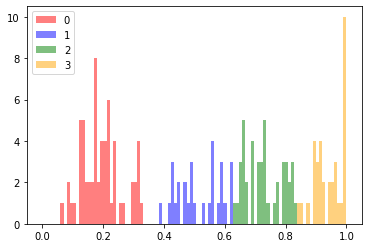

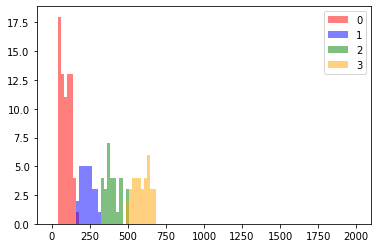

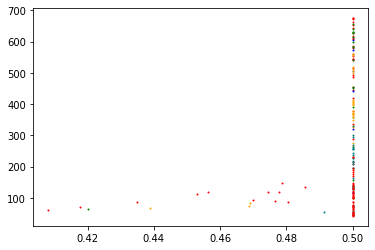

In [190]:
import sklearn

cid = ['cluster36','cluster44','cluster57','cluster70','cluster90','cluster91']

df_a = df
df_a = bpy.get_best(df_a,['query_id'],metric='match_score',stat='idxmax')
c2 = df_a['database_id'].isin(cid)
df_a = df_a[c2]

metric = 'm1'
df_a = df_a.rename(columns={'query_id':'id'})
y = bpy.cluster_Kmeans(df_a[['id',metric]], n_clusters=4, ordered=True)

plt.figure(1)
R = np.linspace(0,1,100)
color = ['red','blue','green','orange','teal']
for i in np.unique(y['cluster_id']):
    c = df_a['id'].isin(y[y['cluster_id']==i]['id'])
    print(i, np.sum(c))
    plt.hist(df_a[c][metric], label=str(i), bins=R, alpha=0.5, color=color[i])
plt.legend()

metric = 's1'
df_a = df_a.rename(columns={'query_id':'id'})
y = bpy.cluster_Kmeans(df_a[['id',metric]], n_clusters=4, ordered=True)

plt.figure(2)
R = np.linspace(0,2000,100)
color = ['red','blue','green','orange','teal']
for i in np.unique(y['cluster_id']):
    c = df_a['id'].isin(y[y['cluster_id']==i]['id'])
    print(i, np.sum(c))
    plt.hist(df_a[c][metric], label=str(i), bins=R, alpha=0.5, color=color[i])
plt.legend()

plt.figure(4)
for i in range(0,len(cid)):
    c = df_a['database_id']==cid[i]
    plt.scatter(df_a[c]['w1'],df_a[c]['s1'],s=1,alpha=1,c=color[i%len(color)])

plt.show()